In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Cell 2: Load the scaled dataset
df_scaled = pd.read_csv('Data/umap_dataset.csv')

# Display basic information
print(f"Dataset shape: {df_scaled.shape}")
print(f"\nFirst few rows:")
df_scaled.head()

Dataset shape: (10492, 20)

First few rows:


,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,UMAP11,UMAP12,UMAP13,UMAP14,UMAP15,UMAP16,UMAP17,UMAP18,UMAP19,UMAP20
0,6.984057,3.946451,5.205351,4.802381,4.384887,4.730973,4.727362,6.604657,5.232395,6.972343,4.387784,4.567963,6.061771,5.456931,4.780723,4.651919,5.059971,4.201286,6.435759,6.274830
1,7.612059,7.103979,6.208079,4.684521,4.501087,5.216638,4.827877,6.766672,4.440826,5.961282,5.079394,4.663627,5.579028,5.869681,4.530921,5.191735,5.513998,4.158608,5.553513,4.492035
2,7.190064,2.817851,4.790741,4.878833,4.551516,4.361865,5.503670,6.246725,4.897294,6.203523,3.609707,4.435886,5.898444,4.922353,4.852436,4.356301,5.094808,4.531821,6.157348,6.534938
3,7.251889,2.645500,4.713510,5.014342,4.416551,4.202064,5.376665,6.082995,4.936111,6.313529,3.673915,4.369023,5.935692,4.627879,5.027231,4.487628,4.971977,4.639008,6.213034,6.765796
4,6.896022,3.963038,5.201747,4.627189,4.290148,4.493001,4.950718,6.761571,4.529400,6.344268,4.190560,4.793908,5.952352,5.084472,5.020196,5.088276,4.795937,3.648349,6.814028,6.504096


In [3]:
# Cell 3: Compute affinity matrix and eigenvalues for eigengap analysis (FIXED)
from sklearn.metrics.pairwise import rbf_kernel

# Calculate gamma value using 'scale' formula manually
# gamma = 1 / (n_features * variance)
n_features = df_scaled.shape[1]
gamma_value = 1.0 / (n_features * df_scaled.var().mean())

print(f"Calculated gamma value: {gamma_value:.6f}")

# Compute affinity matrix using RBF kernel with calculated gamma
affinity_matrix = rbf_kernel(df_scaled, gamma=gamma_value)

# Compute graph Laplacian
degree_matrix = np.diag(affinity_matrix.sum(axis=1))
laplacian = degree_matrix - affinity_matrix

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

# Sort eigenvalues in ascending order
sorted_eigenvalues = np.sort(eigenvalues)

print(f"\nFirst 10 eigenvalues: {sorted_eigenvalues[:10]}")

Calculated gamma value: 0.034648

First 10 eigenvalues: [2.47915208e-12 1.87238759e+01 4.33725996e+01 5.13246042e+01
 5.13264986e+01 5.13269054e+01 5.13274705e+01 5.13289641e+01
 5.13300268e+01 5.13324065e+01]


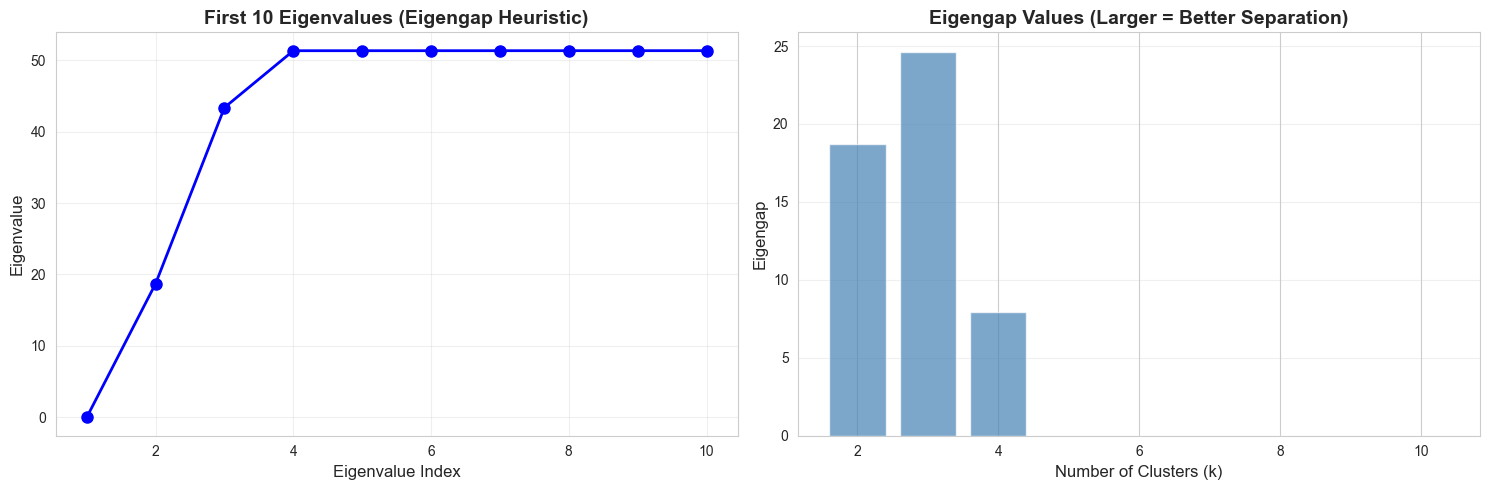


Suggested k from eigengap heuristic: 3


In [4]:
# Cell 4: Plot eigengap to identify optimal k
# Calculate eigengaps (differences between consecutive eigenvalues)
eigengaps = np.diff(sorted_eigenvalues[:15])

# Plot eigenvalues
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Eigenvalues
axes[0].plot(range(1, 11), sorted_eigenvalues[:10], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Eigenvalue Index', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title('First 10 Eigenvalues (Eigengap Heuristic)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Eigengaps
axes[1].bar(range(2, 11), eigengaps[:9], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Eigengap', fontsize=12)
axes[1].set_title('Eigengap Values (Larger = Better Separation)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find k with largest eigengap
optimal_k_eigengap = np.argmax(eigengaps[:6]) + 2  # +2 because eigengaps start from k=2
print(f"\nSuggested k from eigengap heuristic: {optimal_k_eigengap}")

In [5]:
# Cell 5: Perform spectral clustering for k=2 to k=7 and compute metrics
k_range = range(2, 8)
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Computing clustering metrics for k=2 to k=7...")
print("-" * 60)

for k in k_range:
    # Perform spectral clustering with calculated gamma value
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='rbf',
        gamma=gamma_value,  # Use the gamma we calculated earlier
        assign_labels='kmeans',
        random_state=42,
        n_init=10
    )
    labels = spectral.fit_predict(df_scaled)
    
    # Compute metrics
    sil_score = silhouette_score(df_scaled, labels)
    db_score = davies_bouldin_score(df_scaled, labels)
    ch_score = calinski_harabasz_score(df_scaled, labels)
    
    silhouette_scores.append(sil_score)
    davies_bouldin_scores.append(db_score)
    calinski_harabasz_scores.append(ch_score)
    
    print(f"k={k} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.2f}")

print("-" * 60)

Computing clustering metrics for k=2 to k=7...
------------------------------------------------------------
k=2 | Silhouette: 0.8138 | Davies-Bouldin: 0.2059 | Calinski-Harabasz: 60408.69
k=3 | Silhouette: 0.5531 | Davies-Bouldin: 0.5466 | Calinski-Harabasz: 54400.25
k=4 | Silhouette: 0.5521 | Davies-Bouldin: 0.4367 | Calinski-Harabasz: 38066.18
k=5 | Silhouette: 0.5040 | Davies-Bouldin: 0.6044 | Calinski-Harabasz: 46824.21
k=6 | Silhouette: 0.5153 | Davies-Bouldin: 0.6176 | Calinski-Harabasz: 50982.05
k=7 | Silhouette: 0.5214 | Davies-Bouldin: 0.6920 | Calinski-Harabasz: 46808.93
------------------------------------------------------------


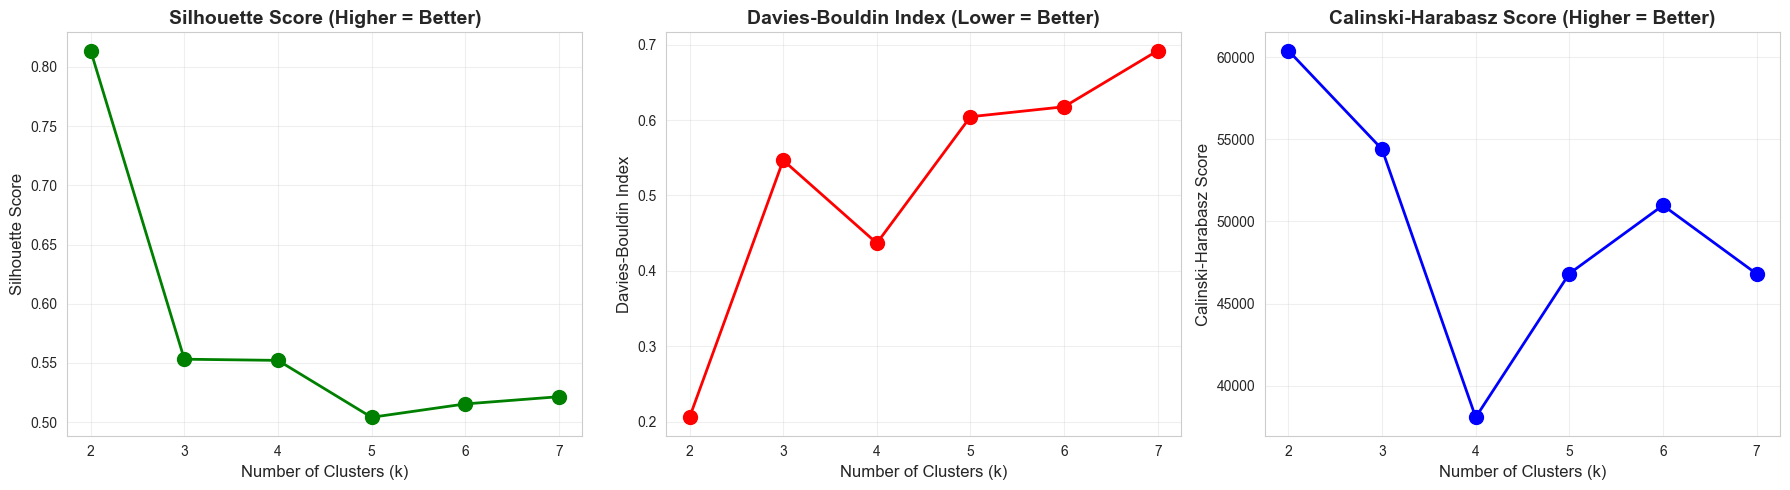


Optimal k based on different metrics:
  - Eigengap Heuristic: k=3
  - Silhouette Score: k=2
  - Davies-Bouldin Index: k=2
  - Calinski-Harabasz Score: k=2


In [6]:
# Cell 6: Visualize clustering metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Silhouette Score (Higher is better)
axes[0].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=10)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Plot 2: Davies-Bouldin Index (Lower is better)
axes[1].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=10)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Plot 3: Calinski-Harabasz Score (Higher is better)
axes[2].plot(k_range, calinski_harabasz_scores, 'bo-', linewidth=2, markersize=10)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[2].set_title('Calinski-Harabasz Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

# Identify optimal k based on each metric
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
optimal_k_ch = k_range[np.argmax(calinski_harabasz_scores)]

print("\nOptimal k based on different metrics:")
print(f"  - Eigengap Heuristic: k={optimal_k_eigengap}")
print(f"  - Silhouette Score: k={optimal_k_silhouette}")
print(f"  - Davies-Bouldin Index: k={optimal_k_db}")
print(f"  - Calinski-Harabasz Score: k={optimal_k_ch}")

In [7]:
# Cell 7: Summary table of all metrics
metrics_df = pd.DataFrame({
    'k': list(k_range),
    'Silhouette': silhouette_scores,
    'Davies_Bouldin': davies_bouldin_scores,
    'Calinski_Harabasz': calinski_harabasz_scores
})

print("\n" + "="*70)
print("SUMMARY TABLE: Clustering Metrics for k=2 to k=7")
print("="*70)
print(metrics_df.to_string(index=False))
print("="*70)
print("\nRecommendation: Choose k based on:")
print("  1. Highest Silhouette Score")
print("  2. Lowest Davies-Bouldin Index")
print("  3. Eigengap suggestion")
print("  4. Domain knowledge (clinical interpretability)")


SUMMARY TABLE: Clustering Metrics for k=2 to k=7
 k  Silhouette  Davies_Bouldin  Calinski_Harabasz
 2    0.813793        0.205884       60408.685554
 3    0.553113        0.546620       54400.246132
 4    0.552110        0.436741       38066.183044
 5    0.504013        0.604398       46824.208549
 6    0.515322        0.617579       50982.052142
 7    0.521425        0.691966       46808.931422

Recommendation: Choose k based on:
  1. Highest Silhouette Score
  2. Lowest Davies-Bouldin Index
  3. Eigengap suggestion
  4. Domain knowledge (clinical interpretability)


In [8]:
# Cell 8: Perform spectral clustering for k=3 and k=4 to check cluster balance
print("Performing Spectral Clustering for k=3 and k=4...")
print("="*70)

# Spectral clustering with k=3
spectral_k3 = SpectralClustering(
    n_clusters=3,
    affinity='rbf',
    gamma=gamma_value,
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)
labels_k3 = spectral_k3.fit_predict(df_scaled)

# Spectral clustering with k=4
spectral_k4 = SpectralClustering(
    n_clusters=4,
    affinity='rbf',
    gamma=gamma_value,
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)
labels_k4 = spectral_k4.fit_predict(df_scaled)

print("\n✓ Clustering complete for both k=3 and k=4")

Performing Spectral Clustering for k=3 and k=4...

✓ Clustering complete for both k=3 and k=4


In [9]:
# Cell 9: Analyze and compare cluster balance for k=3 and k=4
import pandas as pd

# Create comparison dataframe
print("\n" + "="*70)
print("CLUSTER SIZE ANALYSIS")
print("="*70)

# k=3 analysis
print("\n--- k=3 Cluster Distribution ---")
unique_k3, counts_k3 = np.unique(labels_k3, return_counts=True)
total_samples = len(labels_k3)

for cluster, count in zip(unique_k3, counts_k3):
    percentage = (count / total_samples) * 100
    print(f"Cluster {cluster}: {count:>5} samples ({percentage:>5.2f}%)")

print(f"\nTotal: {total_samples} samples")
print(f"Largest cluster: {counts_k3.max()} ({(counts_k3.max()/total_samples)*100:.2f}%)")
print(f"Smallest cluster: {counts_k3.min()} ({(counts_k3.min()/total_samples)*100:.2f}%)")
print(f"Balance ratio (min/max): {counts_k3.min()/counts_k3.max():.3f}")

# k=4 analysis
print("\n--- k=4 Cluster Distribution ---")
unique_k4, counts_k4 = np.unique(labels_k4, return_counts=True)

for cluster, count in zip(unique_k4, counts_k4):
    percentage = (count / total_samples) * 100
    print(f"Cluster {cluster}: {count:>5} samples ({percentage:>5.2f}%)")

print(f"\nTotal: {total_samples} samples")
print(f"Largest cluster: {counts_k4.max()} ({(counts_k4.max()/total_samples)*100:.2f}%)")
print(f"Smallest cluster: {counts_k4.min()} ({(counts_k4.min()/total_samples)*100:.2f}%)")
print(f"Balance ratio (min/max): {counts_k4.min()/counts_k4.max():.3f}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("- Balance ratio closer to 1.0 = more balanced clusters")
print("- Avoid clusters with <5% of data (too small for reliable patterns)")
print("- Ideal: Each cluster has 15-40% of total data")
print("="*70)


CLUSTER SIZE ANALYSIS

--- k=3 Cluster Distribution ---
Cluster 0:  1722 samples (16.41%)
Cluster 1:  7009 samples (66.80%)
Cluster 2:  1761 samples (16.78%)

Total: 10492 samples
Largest cluster: 7009 (66.80%)
Smallest cluster: 1722 (16.41%)
Balance ratio (min/max): 0.246

--- k=4 Cluster Distribution ---
Cluster 0:  7003 samples (66.75%)
Cluster 1:     8 samples ( 0.08%)
Cluster 2:  1722 samples (16.41%)
Cluster 3:  1759 samples (16.77%)

Total: 10492 samples
Largest cluster: 7003 (66.75%)
Smallest cluster: 8 (0.08%)
Balance ratio (min/max): 0.001

INTERPRETATION:
- Balance ratio closer to 1.0 = more balanced clusters
- Avoid clusters with <5% of data (too small for reliable patterns)
- Ideal: Each cluster has 15-40% of total data


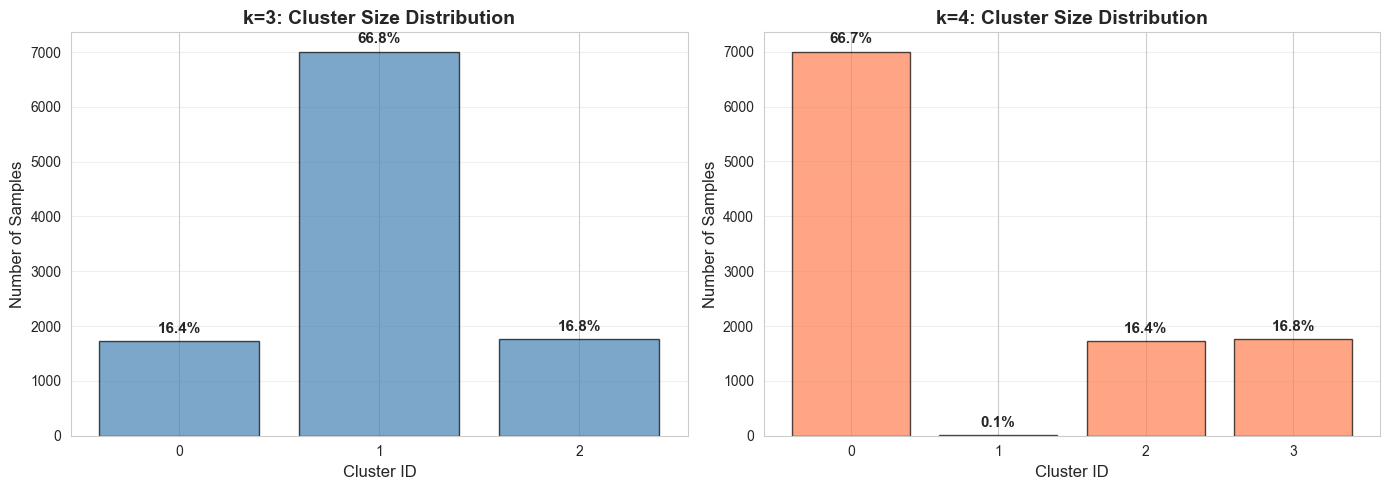


Decision Guide:
- Choose k=3 if: More balanced distribution, clearer separation
- Choose k=4 if: No cluster is <10%, want more granularity


In [10]:
# Cell 10: Visualize cluster balance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for k=3
axes[0].bar(unique_k3, counts_k3, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('k=3: Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(unique_k3)
axes[0].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for i, (cluster, count) in enumerate(zip(unique_k3, counts_k3)):
    percentage = (count / total_samples) * 100
    axes[0].text(cluster, count + 100, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot for k=4
axes[1].bar(unique_k4, counts_k4, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Cluster ID', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('k=4: Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(unique_k4)
axes[1].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for i, (cluster, count) in enumerate(zip(unique_k4, counts_k4)):
    percentage = (count / total_samples) * 100
    axes[1].text(cluster, count + 100, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDecision Guide:")
print("- Choose k=3 if: More balanced distribution, clearer separation")
print("- Choose k=4 if: No cluster is <10%, want more granularity")

### Okay so lets d clustering on k=3 and then sub cluster the larger clusters again into smaller clusters similar to the above approach!

In [18]:
# Cell 11: Final spectral clustering with k=2 and save results
print("="*70)
print("FINAL SPECTRAL CLUSTERING WITH k=2")
print("="*70)

# Perform spectral clustering with k=2
final_spectral = SpectralClustering(
    n_clusters=5,
    affinity='rbf',
    gamma=gamma_value,
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)

# Get cluster labels
cluster_labels = final_spectral.fit_predict(df_scaled)

# Add cluster labels to the dataframe
df_scaled['Spectral_Cluster'] = cluster_labels

# Display cluster distribution
unique, counts = np.unique(cluster_labels, return_counts=True)
total_samples = len(cluster_labels)

print("\nCluster Distribution:")
for cluster, count in zip(unique, counts):
    percentage = (count / total_samples) * 100
    print(f"Cluster {cluster}: {count} samples ({percentage:.2f}%)")

print(f"\nTotal: {total_samples} samples")

# Save the clustered dataset
df_scaled.to_csv('Data/df_spectral_k2_clustered.csv', index=False)
print(f"\n✓ Saved clustered dataset to: Data/df_spectral_k2_clustered.csv")
print("="*70)

FINAL SPECTRAL CLUSTERING WITH k=2

Cluster Distribution:
Cluster 0: 1722 samples (16.41%)
Cluster 1: 8 samples (0.08%)
Cluster 2: 3937 samples (37.52%)
Cluster 3: 3088 samples (29.43%)
Cluster 4: 1737 samples (16.56%)

Total: 10492 samples

✓ Saved clustered dataset to: Data/df_spectral_k2_clustered.csv


In [19]:
# Cell 12: Identify and extract the larger cluster for sub-clustering
print("\n" + "="*70)
print("PREPARING LARGER CLUSTER FOR SUB-CLUSTERING")
print("="*70)

# Get cluster sizes
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCluster sizes:")
for cluster, count in cluster_sizes.items():
    percentage = (count / total_samples) * 100
    print(f"Cluster {cluster}: {count} samples ({percentage:.2f}%)")

# Identify the larger cluster
larger_cluster_id = cluster_sizes.idxmax()
larger_cluster_size = cluster_sizes.max()

print(f"\nLarger cluster: Cluster {larger_cluster_id}")
print(f"Size: {larger_cluster_size} samples ({(larger_cluster_size/total_samples)*100:.2f}%)")

# Extract data for the larger cluster (excluding the 'Spectral_Cluster' column)
larger_cluster_data = df_scaled[df_scaled['Spectral_Cluster'] == larger_cluster_id].drop('Spectral_Cluster', axis=1)

# Get original indices to map back later
larger_cluster_indices = df_scaled[df_scaled['Spectral_Cluster'] == larger_cluster_id].index

print(f"\n✓ Extracted larger cluster data: {larger_cluster_data.shape}")
print(f"✓ Stored {len(larger_cluster_indices)} indices for mapping")
print("="*70)


PREPARING LARGER CLUSTER FOR SUB-CLUSTERING

Cluster sizes:
Cluster 0: 1722 samples (16.41%)
Cluster 1: 8 samples (0.08%)
Cluster 2: 3937 samples (37.52%)
Cluster 3: 3088 samples (29.43%)
Cluster 4: 1737 samples (16.56%)

Larger cluster: Cluster 2
Size: 3937 samples (37.52%)

✓ Extracted larger cluster data: (3937, 20)
✓ Stored 3937 indices for mapping



EIGENGAP ANALYSIS FOR CLUSTER 2 SUB-CLUSTERING
Calculated gamma for Cluster 2: 0.573333


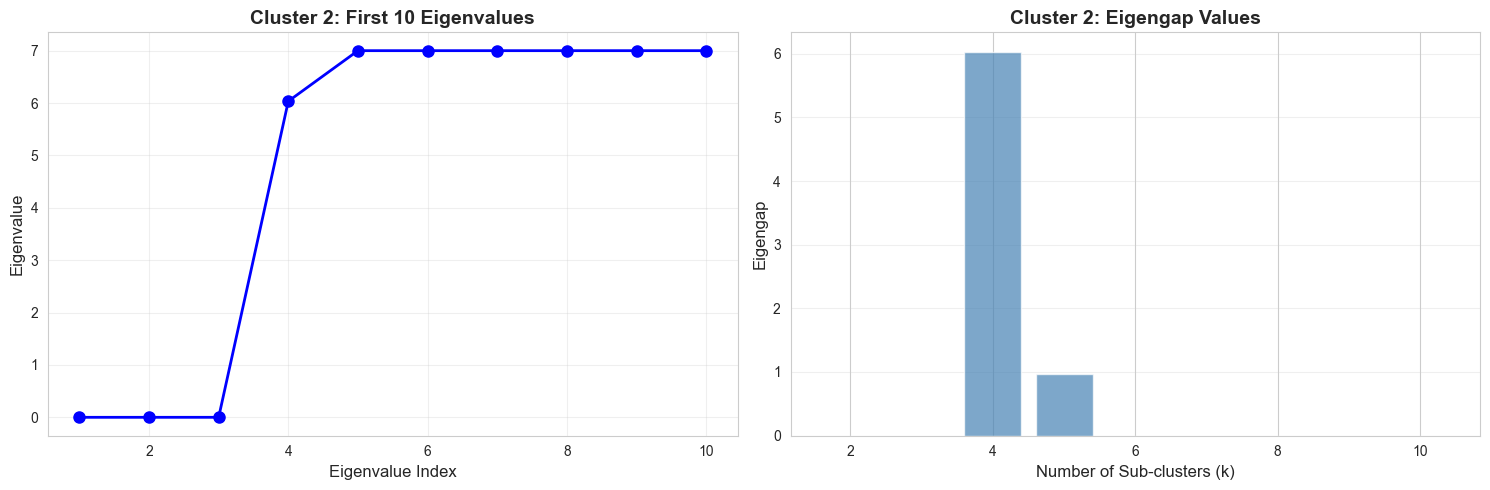


Suggested k from eigengap for Cluster 2: 4


In [20]:
# Cell 13: Eigengap analysis for larger cluster sub-clustering
print("\n" + "="*70)
print(f"EIGENGAP ANALYSIS FOR CLUSTER {larger_cluster_id} SUB-CLUSTERING")
print("="*70)

# Calculate gamma for this subset
n_features_large = larger_cluster_data.shape[1]
gamma_large = 1.0 / (n_features_large * larger_cluster_data.var().mean())
print(f"Calculated gamma for Cluster {larger_cluster_id}: {gamma_large:.6f}")

# Compute affinity matrix
affinity_large = rbf_kernel(larger_cluster_data, gamma=gamma_large)

# Compute Laplacian
degree_large = np.diag(affinity_large.sum(axis=1))
laplacian_large = degree_large - affinity_large

# Eigendecomposition
eigenvalues_large, _ = np.linalg.eigh(laplacian_large)
sorted_eigenvalues_large = np.sort(eigenvalues_large)

# Calculate eigengaps
eigengaps_large = np.diff(sorted_eigenvalues_large[:10])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, 11), sorted_eigenvalues_large[:10], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Eigenvalue Index', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title(f'Cluster {larger_cluster_id}: First 10 Eigenvalues', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(2, 11), eigengaps_large[:9], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Number of Sub-clusters (k)', fontsize=12)
axes[1].set_ylabel('Eigengap', fontsize=12)
axes[1].set_title(f'Cluster {larger_cluster_id}: Eigengap Values', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Suggest k
optimal_k_large = np.argmax(eigengaps_large[:5]) + 2
print(f"\nSuggested k from eigengap for Cluster {larger_cluster_id}: {optimal_k_large}")
print("="*70)

In [21]:
# Cell 14: Compute clustering metrics for larger cluster sub-clustering (k=2 to k=5)
print("\n" + "="*70)
print(f"COMPUTING METRICS FOR CLUSTER {larger_cluster_id} SUB-CLUSTERING")
print("="*70)

k_range_sub = range(2, 6)
sil_scores_sub = []
db_scores_sub = []
ch_scores_sub = []

print(f"Testing sub-clustering for k=2 to k=5...")
print("-" * 60)

for k in k_range_sub:
    spectral_sub = SpectralClustering(
        n_clusters=k,
        affinity='rbf',
        gamma=gamma_large,
        assign_labels='kmeans',
        random_state=42,
        n_init=10
    )
    sub_labels = spectral_sub.fit_predict(larger_cluster_data)
    
    sil = silhouette_score(larger_cluster_data, sub_labels)
    db = davies_bouldin_score(larger_cluster_data, sub_labels)
    ch = calinski_harabasz_score(larger_cluster_data, sub_labels)
    
    sil_scores_sub.append(sil)
    db_scores_sub.append(db)
    ch_scores_sub.append(ch)
    
    print(f"k={k} | Silhouette: {sil:.4f} | Davies-Bouldin: {db:.4f} | Calinski-Harabasz: {ch:.2f}")

print("-" * 60)

# Identify optimal k
optimal_k_sil_sub = k_range_sub[np.argmax(sil_scores_sub)]
optimal_k_db_sub = k_range_sub[np.argmin(db_scores_sub)]
optimal_k_ch_sub = k_range_sub[np.argmax(ch_scores_sub)]

print(f"\nOptimal k for Cluster {larger_cluster_id} sub-clustering:")
print(f"  - Eigengap: k={optimal_k_large}")
print(f"  - Silhouette: k={optimal_k_sil_sub}")
print(f"  - Davies-Bouldin: k={optimal_k_db_sub}")
print(f"  - Calinski-Harabasz: k={optimal_k_ch_sub}")
print("="*70)


COMPUTING METRICS FOR CLUSTER 2 SUB-CLUSTERING
Testing sub-clustering for k=2 to k=5...
------------------------------------------------------------
k=2 | Silhouette: 0.7403 | Davies-Bouldin: 0.1899 | Calinski-Harabasz: 166.10
k=3 | Silhouette: 0.7192 | Davies-Bouldin: 0.1990 | Calinski-Harabasz: 182.30
k=4 | Silhouette: 0.5930 | Davies-Bouldin: 0.2473 | Calinski-Harabasz: 150.70
k=5 | Silhouette: 0.5205 | Davies-Bouldin: 0.2777 | Calinski-Harabasz: 131.29
------------------------------------------------------------

Optimal k for Cluster 2 sub-clustering:
  - Eigengap: k=4
  - Silhouette: k=2
  - Davies-Bouldin: k=2
  - Calinski-Harabasz: k=3


In [22]:
# Cell 15: Test sub-clustering with k=2 to k=5 and show distributions
print("="*70)
print("TESTING SUB-CLUSTERING WITH k=2 TO k=5")
print("="*70)

# Store results for each k
sub_clustering_results = {}

for k in range(2, 6):
    print(f"\n{'='*70}")
    print(f"Testing k={k} sub-clustering")
    print(f"{'='*70}")
    
    # Perform sub-clustering
    spectral_sub = SpectralClustering(
        n_clusters=k,
        affinity='rbf',
        gamma=gamma_large,
        assign_labels='kmeans',
        random_state=42,
        n_init=10
    )
    sub_labels = spectral_sub.fit_predict(larger_cluster_data)
    
    # Get distribution
    unique_labels, counts = np.unique(sub_labels, return_counts=True)
    
    # Store results
    sub_clustering_results[k] = {
        'labels': sub_labels,
        'counts': counts
    }
    
    # Display distribution
    print(f"\nSub-cluster distribution for k={k}:")
    print("-" * 60)
    for sub_cluster, count in zip(unique_labels, counts):
        percentage = (count / len(sub_labels)) * 100
        percentage_of_total = (count / len(df_scaled)) * 100
        print(f"  Sub-cluster {sub_cluster}: {count:>5} samples ({percentage:>5.2f}% of Cluster {larger_cluster_id}, {percentage_of_total:>5.2f}% of total)")
    
    # Balance metrics
    balance_ratio = counts.min() / counts.max()
    print(f"\nBalance ratio (min/max): {balance_ratio:.3f}")
    print(f"Largest sub-cluster: {counts.max()} ({(counts.max()/len(sub_labels))*100:.2f}%)")
    print(f"Smallest sub-cluster: {counts.min()} ({(counts.min()/len(sub_labels))*100:.2f}%)")

print("\n" + "="*70)
print("SUMMARY OF ALL TESTED k VALUES")
print("="*70)

# Create summary comparison
summary_data = []
for k in range(2, 6):
    counts = sub_clustering_results[k]['counts']
    summary_data.append({
        'k': k,
        'Largest': counts.max(),
        'Smallest': counts.min(),
        'Balance_Ratio': f"{counts.min()/counts.max():.3f}",
        'Distribution': ' / '.join([str(c) for c in counts])
    })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n" + "="*70)
print("RECOMMENDATION:")
print("Based on the metrics from Cell 14:")
print("  - All metrics agreed on k=2")
print("  - But review the balance above to make final decision")
print("="*70)

TESTING SUB-CLUSTERING WITH k=2 TO k=5

Testing k=2 sub-clustering

Sub-cluster distribution for k=2:
------------------------------------------------------------
  Sub-cluster 0:  3930 samples (99.82% of Cluster 2, 37.46% of total)
  Sub-cluster 1:     7 samples ( 0.18% of Cluster 2,  0.07% of total)

Balance ratio (min/max): 0.002
Largest sub-cluster: 3930 (99.82%)
Smallest sub-cluster: 7 (0.18%)

Testing k=3 sub-clustering

Sub-cluster distribution for k=3:
------------------------------------------------------------
  Sub-cluster 0:  3921 samples (99.59% of Cluster 2, 37.37% of total)
  Sub-cluster 1:     7 samples ( 0.18% of Cluster 2,  0.07% of total)
  Sub-cluster 2:     9 samples ( 0.23% of Cluster 2,  0.09% of total)

Balance ratio (min/max): 0.002
Largest sub-cluster: 3921 (99.59%)
Smallest sub-cluster: 7 (0.18%)

Testing k=4 sub-clustering

Sub-cluster distribution for k=4:
------------------------------------------------------------
  Sub-cluster 0:  3913 samples (99.39% of

### So the clustering in this has only 15 samples in one cluster - making it irrelevant